# Distributions example -  elections

##### Keywords: bernoulli distribution, binomial, normal distribution, central limit theorem, uniform distribution, empirical distribution, elections

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist

sns.set_style("white")
colors=sns.color_palette()

In the last section, we made a simple simulation of a coin-toss on the computer from a fair-coin model which associated equal probability with heads and tails. Let us consider another model here, a table of probabilities that [PredictWise](http://www.predictwise.com/results/2012/president) made on October 2, 2012 for the US presidential elections. 
PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:

In [2]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


Say you toss a coin and have a model which says that the probability of heads is 0.5 (you have figured this out from symmetry, or physics, or something). Still, there will be sequences of flips in which more or less than half the flips are heads.  These **fluctuations** induce a distribution on the number of heads (say k) in N coin tosses (this is a binomial distribution).

Similarly, here, if the probability of Romney winning in Arizona is 0.938, it means that if somehow, there were 10000 replications (as if we were running the election in 10000 parallel universes) with an election each, Romney would win in 9380 of those Arizonas **on the average** across the replications. And there would be some replications with Romney winning more, and some with less. We can run these **simulated** universes or replications on a computer though not in real life.

## Simulating a simple election model

To do this, 
we will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by the Predictwise state-wise win probabilities. Lets write a function `simulate_election` that uses this **predictive model** to simulate the outcome of the election given a table of probabilities.

### Bernoulli Random Variables (in scipy.stats)

The **Bernoulli Distribution** represents the distribution for coin flips. Let the random variable X represent such a coin flip, where X=1 is heads, and X=0 is tails. Let us further say that the probability of heads is p (p=0.5 is a fair coin). 

We then say:

$$X \sim Bernoulli(p),$$

which is to be read as **X has distribution Bernoulli(p)**. The **probability distribution function (pdf)** or **probability mass function** associated with the Bernoulli distribution is

$$\begin{eqnarray}
P(X = 1) &=& p \\
P(X = 0) &=& 1 - p 
\end{eqnarray}$$

for p in the range 0 to 1. 
The **pdf**, or the probability that random variable $X=x$ may thus be written as 

$$P(X=x) = p^x(1-p)^{1-x}$$

for x in the set {0,1}.

The Predictwise probability of Obama winning in each state is a Bernoulli Parameter. You can think of it as a different loaded coin being tossed in each state, and thus there is a bernoulli distribution for each state

Note: **some of the code, and ALL of the visual style for the distribution plots below was shamelessly stolen from https://gist.github.com/mattions/6113437/ **.

Text(0.5, 0.98, 'Bernoulli probability')

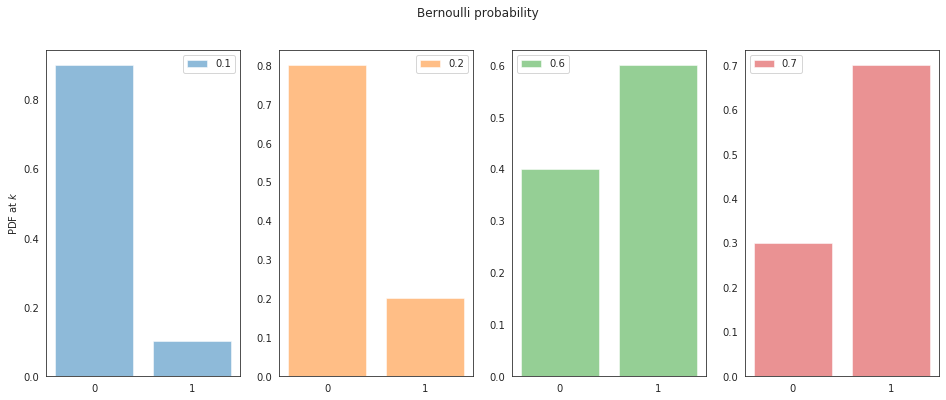

In [3]:
a = torch.tensor([1., 0.])

plt.figure(figsize=(16, 6))
for i, p in enumerate([0.1, 0.2, 0.6, 0.7]):
    ax = plt.subplot(1, 4, i+1)
#     plt.bar(a, bernoulli.pmf(a, p), label=p, color=colors[i], alpha=0.5)
    plt.bar(a.numpy(), dist.Bernoulli(p).log_prob(a).exp().numpy(), label=p, color=colors[i], alpha=0.5)
    ax.xaxis.set_ticks(a)

    plt.legend(loc=0)
    if i == 0:
        plt.ylabel("PDF at $k$")
    

plt.suptitle("Bernoulli probability")

### Running the simulation using the Uniform distribution

In the code below, each column simulates a single outcome from the 50 states + DC by choosing a random number between 0 and 1. Obama wins that simulation if the random number is $<$ the win probability. If he wins that simulation, we add in the electoral votes for that state, otherwise we dont. We do this `n_sim` times and return a list of total Obama electoral votes in each simulation.

In [18]:
def simulate_election(model, n_sim):
    simulations = dist.Uniform(0, 1).sample((51, n_sim)).numpy()
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)

The first thing to pick up on here is that `np.random.uniform` gives you a random number between 0 and 1, uniformly. In other words, the number is equally likely to be between 0 and 0.1, 0.1 and 0.2, and so on. This is a very intuitive idea, but it is formalized by the notion of the **Uniform Distribution**.

We then say:

$$X \sim Uniform([0,1),$$

which is to be read as **X has distribution Uniform([0,1])**. The **probability distribution function (pdf)** associated with the Uniform distribution is

\begin{eqnarray}
P(X = x) &=& 1 \, for \, x \in [0,1] \\
P(X = x) &=& 0 \, for \, x \notin [0,1]
\end{eqnarray}

What assigning the vote to Obama when the random variable **drawn** from the Uniform distribution is less than the Predictwise probability of Obama winning (which is a Bernoulli Parameter) does for us is this: if we have a large number of simulations and $p_{Obama}=0.7$ , then 70\% of the time, the random numbes drawn will be below 0.7. And then, assigning those as Obama wins will hew to the frequentist notion of probability of the Obama win. But remember, of course, that in 30% of the simulations, Obama wont win, and this will induce fluctuations and a distribution on the total number of electoral college votes that Obama gets. And this is what we see in the histogram below. 

The following code takes the necessary probabilities for the Predictwise data, and runs 10000 simulations. If you think of this in terms of our coins, think of it as having 51 biased coins, one for each state, and tossing them 10,000 times each.

We use the results to compute the number of simulations, according to this predictive model, that Obama wins the election (i.e., the probability that he receives 269 or more electoral college votes)

In [19]:
result = simulate_election(predictwise, 10000)
print((result >= 269).sum())

9966


In [20]:
result

array([303, 290, 330, ..., 306, 332, 347])

There are roughly only 50 simulations in which Romney wins the election!

## Displaying the prediction

Now, lets visualize the simulation. We will build a histogram from the result of `simulate_election`. We will **normalize** the histogram by dividing the frequency of a vote tally by the number of simulations. We'll overplot the "victory threshold" of 269 votes as a vertical black line and the result (Obama winning 332 votes) as a vertical red line.

We also compute the number of votes at the 5th and 95th quantiles, which we call the spread, and display it (this is an estimate of the outcome's uncertainty). By 5th quantile we mean that if we ordered the number of votes Obama gets in each simulation in increasing order, the 5th quantile is the number below which 5\% of the simulations lie. 

We also display the probability of an Obama victory    
    

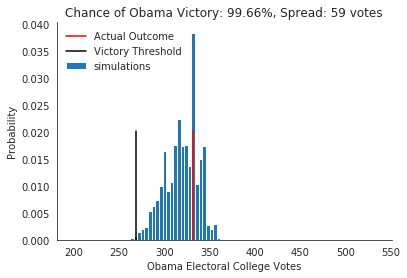

In [53]:
def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 4), label='simulations', align='left', density=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    sns.despine()

plot_simulation(result)

The model created by combining the probabilities we obtained from Predictwise with the simulation of a biased coin flip corresponding to the win probability in each states leads us to obtain a histogram of election outcomes. We are plotting the probabilities of a prediction, so we call this distribution over outcomes the **predictive distribution**. Simulating from our model and plotting a histogram allows us to visualize this predictive distribution. In general, such a set of probabilities is called a  **probability mass function**. 

## Empirical Distribution

This is an **empirical Probability Mass Function**. 

Lets summarize: the way the mass function arose here that we did ran 10,000 tosses (for each state), and depending on the value, assigned the state to Obama or Romney, and then summed up the electoral votes over the states.

There is a second, very useful question, we can ask of any such probability mass or probability density: what is the probability that a random variable is less than some value. In other words: $P(X < x)$. This is *also* a probability distribution and is called the **Cumulative Distribution Function**, or CDF (sometimes just called the **distribution**, as opposed to the **density**, or **mass function**). Its obtained by "summing" the probability density function for all $X$ less than $x$.

In [25]:
CDF = lambda x: np.float(np.sum(result < x))/result.shape[0]
for votes in [200, 300, 320, 340, 360, 400, 500]:
    print("Obama Win CDF at votes=", votes, " is ", CDF(votes))

Obama Win CDF at votes= 200  is  0.0
Obama Win CDF at votes= 300  is  0.1439
Obama Win CDF at votes= 320  is  0.4479
Obama Win CDF at votes= 340  is  0.837
Obama Win CDF at votes= 360  is  0.9982
Obama Win CDF at votes= 400  is  1.0
Obama Win CDF at votes= 500  is  1.0


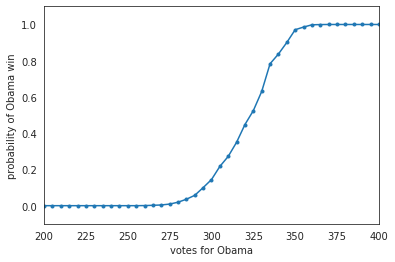

In [26]:
votelist=np.arange(0, 540, 5)
plt.plot(votelist, [CDF(v) for v in votelist], '.-');
plt.xlim([200,400])
plt.ylim([-0.1,1.1])
plt.xlabel("votes for Obama")
plt.ylabel("probability of Obama win");

## Binomial Distribution 

Let us consider a population of coinflips, n of them to be precise, $x_1,x_2,...,x_n$. The distribution of coin flips is the binomial distribution. By this we mean that each coin flip represents a bernoulli random variable (or comes from a bernoulli distribution) with $p=0.5$.

At this point, you might want to ask the question, what is the probability of obtaining $k$ heads in $n$ flips of the coin. We have seen this before, when we flipped 2 coins. What happens when when we flip 3?

(This diagram is taken from the Feynman Lectures on Physics, volume 1. The chapter on probability is http://www.feynmanlectures.caltech.edu/I_06.html)
![3 coin flips](../images/3flips.png)

We draw a possibilities diagram like we did with the 2 coin flips, and see that there are different probabilities associated with the events of 0, 1,2, and 3 heads with 1 and 2 heads being the most likely. 
The probability of each of these events is given by the **Binomial Distribution**, the distribution of the number of successes in a sequence of $n$ independent yes/no experiments, or Bernoulli trials, each of which yields success with probability $p$. The Binomial distribution is an extension of the Bernoulli when $n>1$ or the Bernoulli is the a special case of the Binomial when $n=1$.   

$$P(X = k; n, p) = {n\choose k}p^k(1-p)^{n-k} $$

where

$${n\choose k}=\frac{n!}{k!(n-k)!}$$

How did we obtain this? The $p^k(1-p)^{n-k}$ comes simply from multiplying the probabilities for each bernoulli trial; there are $k$ 1's or yes's, and $n-k$ 0's or no's. The ${n\choose k}$ comes from counting the number of ways in which each event happens: this corresponds to counting all the paths that give the same number of heads in the diagram above.

We show the distribution below for 200 trials.

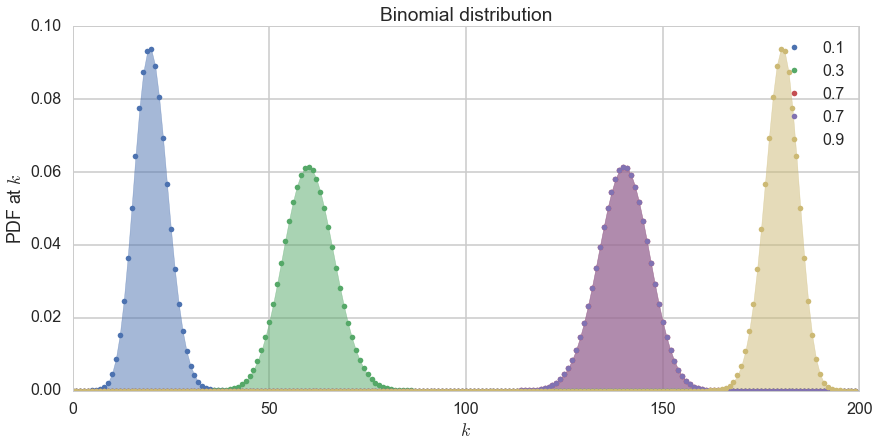

In [12]:
from scipy.stats import binom
plt.figure(figsize=(12,6))
k = np.arange(0, 200)
for p, color in zip([0.1, 0.3, 0.7, 0.7, 0.9], colors):
    rv = binom(200, p)
    plt.plot(k, rv.pmf(k), '.', lw=2, color=color, label=p)
    plt.fill_between(k, rv.pmf(k), color=color, alpha=0.5)
q=plt.legend()
plt.title("Binomial distribution")
plt.tight_layout()
q=plt.ylabel("PDF at $k$")
q=plt.xlabel("$k$")

### Applying the CLT to elections: Binomial distribution in the large n, large k limit

Consider the binomial distribution Binomial(n,k, p) in the limit of large n. The number of successes k in n trials can be regarded as the sum of n IID Bernoulli variables with values 1 or 0.  Call these $x_i$.

Then:

$$S_n = \frac{1}{n} \sum_i x_i .$$


The CLT tells us then that for large n,  we have:

$$S_n \sim N(p, \frac{p(1-p)}{n}),$$

since the mean of a Bernoulli is $p$, and its variance $p*(1-p)$.

This means that we can replace the binomial distribution at large n by a gaussian where k is now a continuous variable, and whose mean is the mean of the binomial $np$ ($nS_n$, since the binomial distribution is on the sum, not on the average) and whose variance is $np(1-p)$.

The accuracy of this approximation depends on the variance. A large variance makes for a broad distribution spanning many discrete k, thus justifying the transition from a discrete to a continuous distribution.

This approximation is used a lot in studying elections. For example, suppose I told you that I'd polled 1000 people in Ohio and found that 600 would vote Democratic, and 400 republican. Imagine that this 1000 is a "sample" drawn from the voting "population" of Ohio. Assume then that these are 1000 independent bernoulli trials with p=600/1000 = 0.6. Then we can say that, from the CLT, the mean of the sampling distribution of the mean of the bernoulli or is 0.6 (equivalently the binomial's mean is 600), with a variance of $0.6*0.4/1000 = 0.00024$ (equivalently the binomials variance is 240). Thus the standard deviation is 0.015 for a mean of 0.6, or 1.5% on a mean of 60% voting Democratic.  This 1.5% if part of what pollsters quote as the margin of error of a candidates winning; they often include other factors such as errors in polling methodology.

### Gallup Party Affiliation Poll

[Earlier](probability.html) we had used the Predictwise probabilities from Octover 12th to create a predictive model for the elections. This time we will try to **estimate** our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with. [Here's the data](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) they collected from January-June of 2012:

In [13]:
gallup_2012=pd.read_csv("data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


Each row lists a state, the percent of surveyed individuals who identify as Democrat/Republican, the percent whose identification is unknown or who haven't made an affiliation yet, the margin between Democrats and Republicans (`Dem_Adv`: the percentage identifying as Democrats minus the percentage identifying as Republicans), and the number `N` of people surveyed.

The most obvious source of error in the Gallup data is the finite sample size -- Gallup did not poll *everybody* in America, and thus the party affilitions are subject to sampling errors. How much uncertainty does this introduce? Lets estimate the sampling error using  the definition of the standard error (we use N-1 rather than N; see the sample error section in the page on the [CLT](SamplingCLT.html)).

In [14]:
gallup_2012["SE_percentage"]=100.0*np.sqrt((gallup_2012.Democrat/100.)*((100. - gallup_2012.Democrat)/100.)/(gallup_2012.N -1))
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown,SE_percentage
State,,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4,0.849059
Alaska,35.9,44.3,-8.4,402,19.8,2.395543
Arizona,39.8,47.3,-7.5,4325,12.9,0.744384
Arkansas,41.5,40.8,0.7,2071,17.7,1.082971
California,48.3,34.6,13.7,16197,17.1,0.392658


On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the sampling error for the states is between 3 and 6%, with it being 3% for most states. This is more than what we find, so lets go with what Gallup says.

We now use Gallup's estimate of 3% to build a Gallup model with some uncertainty. We will, using the CLT, assume that the sampling distribution of the Obama win percentage is a gaussian with mean the democrat percentage and standard error the sampling error of 3\%. 

We'll build the model in the function `uncertain_gallup_model`, and return a forecast where the probability of an Obama victory is given by the probability that a sample from the `Dem_Adv` Gaussian is positive.

To do this we simply need to find the area under the curve of a Gaussian that is on the positive side of the x-axis.
The probability that a sample from a Gaussian with mean $\mu$ and standard deviation $\sigma$ exceeds a threhold $z$ can be found using the the Cumulative Distribution Function of a Gaussian:

$$
CDF(z) = \frac1{2}\left(1 + {\mathrm erf}\left(\frac{z - \mu}{\sqrt{2 \sigma^2}}\right)\right) 
$$

In [15]:
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    prob =  .5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(dict(Obama=prob), index=gallup.index)

In [16]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(predictwise.Votes)

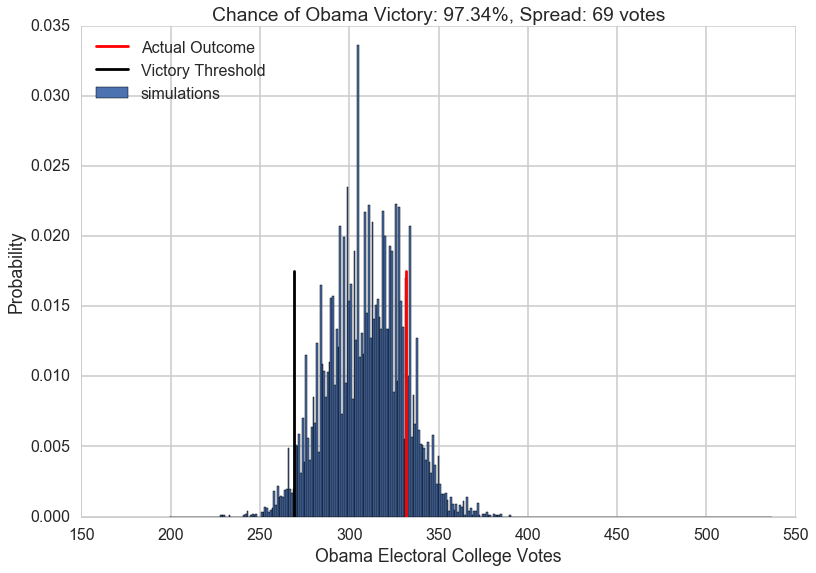

In [17]:
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

### Multiple Pollsters

If one has results from multiple pollsters, one can now treat them as independent samples from the voting population. Now we use the CLT again. Then the average from these samples will approach the average in the population, with the sample means distributed normally around it. So we can average the averages of the samples to get the population mean, and estimate the variance around this population mean as well.